<a href="https://colab.research.google.com/github/heonyun/Causal-Inference-with-Python/blob/main/causal-inference-for-the-brave-and-true/03-Stats-Review-The-Most-Dangerous-Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - Stats Review: The Most Dangerous Equation

2007년 Howard Wainer는 매우 위험한 공식에 관하여 적었습니다.
"어떤 공식들은 알고 있으면 위험하고, 어떤 공식들은 모르고 있으면 위험합니다. 첫째는 경계 내의 비밀에 끔찍한 위험이 내재되어 있기 때문입니다. 이와 같은 공식은 아인슈타인의 상징적인 $E = MC^2$인데, 평범한 물질 안에 숨겨진 거대한 에너지의 척도를 제공하기 때문입니다. 대신 저는 우리가 모를 때 위험을 방출하는 공식들에 관심을 갖고 있습니다. 이 공식들은 가까이서 보면 사물들에 대해 명확하게 이해시켜주지만, 이 공식들의 부재는 우리를 위험하게 할 정도로 무지하게 만듭니다."

그가 말한 공식은 Moivre's equation으로 아래와 같습니다:
$
SE = \frac{\sigma}{\sqrt{n}}
$
위 식에서 SE는 평균의 표준오차, $\sigma$는 표준편차, 그리고 n은 표본 크기를 의미합니다. 용감하고 진실된 사람이 정복해야 할 수학처럼 들리지만, 한번 시작해봅시다!

이 공식을 모르는 것이 왜 매우 위험한지 알아보기 위해, 교육 데이터를 살펴봅시다. 저는 ENEM 점수(SAT와 유사한 브라질 표준 고등학교 점수)를 3년 동안 다른 학교들에서 수집했습니다. 또한 저는, 우리와 관련된 정보를 유지하기 위해 데이터를 전처리했습니다. 원본 데이터는 [Inep website](http://portal.inep.gov.br/web/guest/microdados#)에서 다운로드 할 수 있습니다.

가장 성적이 좋은 학교를 보면, 눈을 끄는 것이 있는데, 학생들의 수가 상당히 적습니다.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [5]:
df = pd.read_csv("enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


In [4]:
import requests

url = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/enem_scores.csv"
file_path = "enem_scores.csv"

response = requests.get(url)
response.raise_for_status() # Raise an exception for HTTP errors

with open(file_path, "wb") as f:
    f.write(response.content)

print(f"'{file_path}' 파일이 성공적으로 다운로드되었습니다.")

'enem_scores.csv' 파일이 성공적으로 다운로드되었습니다.


다른 각도에서 보면 상위 1% 학교만 분리하고 연구할 수 있습니다. 어떻게 생겼나요? 아마도 우리는 최고로부터 배울 수 있고 다른 곳에서 복제할 수 있습니다. 그리고 당연히, 상위 1% 학교를 보면, 평균적으로 학생이 적음을 알 수 있습니다.

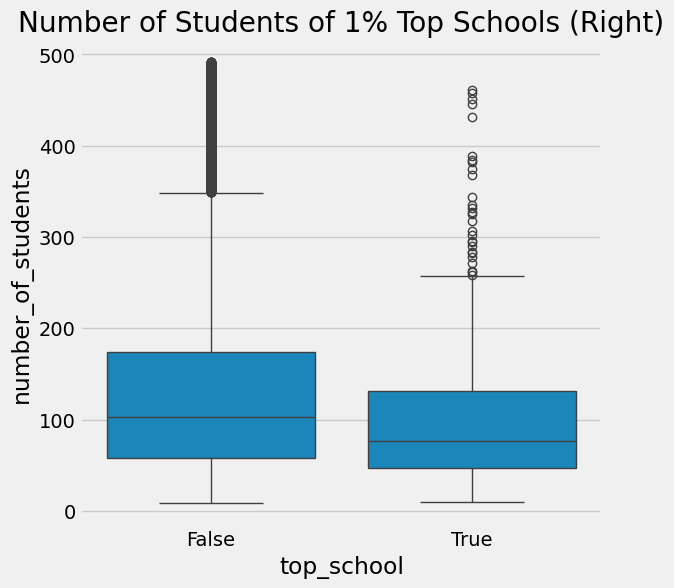

In [6]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

한 가자 당연한 결론은, 작은 학교들이 더 높은 학업 성취를 이끌어낸다는 것입니다. 이는 직관적으로 교사 한 명당 맡은 학생 수가 적을 때, 교사가 각 학생에게 주의를 기울일 수 있기 때문입니다. 그러나 이것이 Moivre's equation과 무슨 연관이 있을까요? 그리고 왜 위험할까요?

이 정보를 기반으로 사람들이 중요하고 비싼 결정들을 한다면 위험해질 것입니다. 그의 기사에서 Howard는 계속 진행합니다.

"1990년대에, 학교 규모를 줄이는 것이 인기가 많았습니다. 수 많은 자선 단체들과 정부 기관들이 더 큰 학교들에게 펀딩을 하였는데, 이는 작은 학교들의 학생들이 높은 시험 점수를 위해 과도하게 대표되긴 했습니다."

사람들은 하위 1%의 학교도 살펴보는 것을 잊었습니다. 만일 우리가 그것을 했더라면, 그들 역시 매우 적은 학생 수를 보여줍니다.

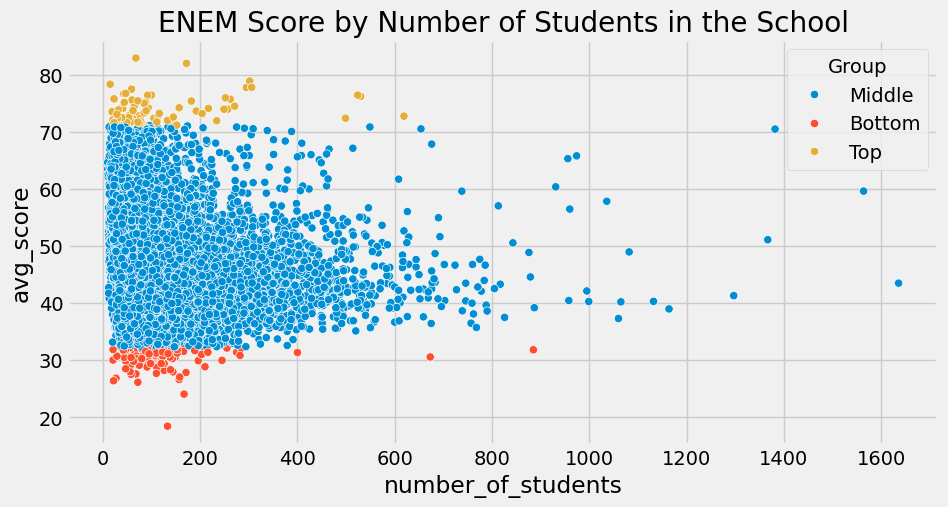

In [7]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

우리는 위의 그래프를 통해 Moivre 공식에서 무엇을 기대하는지 명확하게 볼 수 있습니다. 학생 수가 증가할 수록, 평균 점수는 더 정확해집니다. 학생 수가 적은 학교들은 운에 의해 매우 높거나 매우 낮은 점수 분포를 보여줍니다. 이 점은 큰 학교들에서는 잘 나타나지 않습니다. Moivre 공식은 정보의 실재화와 데이터 기록 형태는 항상 정확하지 않다는 기본적인 사실에 대해서 이야기 합니다. 그렇다면 질문은 얼마나 정확하지 않을까요?

통계학은 이러한 부정확한 것에 대해 다루는 과학이라 우리의 허를 찌르지 않습니다. Taleb은 자신의 책에 무작위에 속았다고 적었습니다.

> 확률은 단순히 주사위 던지기나 더 복잡한 것들에 대해 계산하는 것이 아닙니다. 확률은 우리의 지식에 대한 확신의 부족함을 인정하고 우리의 무지를 대하는 방법들을 발전하는 방법입니다.

불확실성을 계산하는 방법 중 하나는 **분산의 추정량**을 구하는 것입니다. 분산은 중심과 가장 있을 것 같은 값으로부터 얼마나 떨어져있는지 알려줍니다. Moivre 공식이 말해주듯이, 불확실성은 관측된 데이터가 클 수록 줄어듭니다. 말이 되죠? 만일 우리가 많은 학생들이 학교에서 잘한다면, 우리는 좋은 학교라고 확신할 수 있습니다. 그렇나 만일 우리가 10명의 학생 중 8명만 잘한다고 하면, 더 의구심이 들어야 합니다. 우연으로 인해 그 학교는 평균 이상의 학생들이 다닐 가능성이 있으니까요.

위의 아름다운 삼각형 그래프는 이 이야기를 보여줍니다. 표본의 수가 작을 때 우리의 추정치는 큰 분산을 갖습니다. 또한 표본이 커질 수록 분산이 줄어듬을 보여줍니다. 학교에서의 평균 점수는 이에 대해 사실이고, 우리가 추정하고 싶은 ATE를 포함한 그 어떤 요약 통계에 대해서도 마찬가지입니다.

## The Standard Error of Our Estimates

지금까지는 통계학의 리뷰였기 때문에 더 빨리 진행하도록 하겠습니다. 만일 분포, 분산, 표준오차에 대해 잘 모르신다면 계속 읽어주시되 추가적인 요소들이 필요함을 명심하시기 바랍니다. MIT의 기초 통계학 수업이 보편적으로 꽤 좋기 때문에 수강할 것을 권장합니다.

이 전 섹션에서 우리는 평균 처리 효과 $E[Y_{1}-Y_{0}]$를 처리 군과 대조 군 평균 간 차이 $E[Y|T=1] - E[Y|T=0]$으로 다뤘습니다. 우리는 온라인 수업의 ATE를 동기부여 사례로 알아냈습니다. 또한 우리는 온라인 수업은 학생들의 수행 점수가 대면 수업일 때 보다 5점 낮은 부정적인 효과도 보았습니다. 이제 우리는 통계적으로 유의한지 확인하고자 합니다.
이를 위해 우리는 표준오차를 추정해야합니다. 우리는 이미 표본크기 n에 대해 알고 있습니다. 표준오차의 추정치는
$\hat{\sigma} = \sqrt{\frac{1}{N-1}\sum_{i=1}^N (x_{i}-\bar{x})^2}$  

$\bar{x}$는 x의 평균을 의미합니다. 다행히도 대부분 프로그래밍 소프트웨어를 통해 이를 구현할 수 있습니다. 판다스에서는 [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html)를 사용합니다.

In [ ]:
data = pd.read_csv("online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319104


## Confidence Intervals

추정치에 대한 표준오차는 확신에 대한 치수입니다. 무슨 의미인지 정확하게 이해하기 위해 우리는 혼란스럽고 격렬한 통계의 물줄기에 빠져야합니다. 빈도주의자 관점에서 데이터는 정확한 데이터 생성 과정에 대한 표현일 뿐입니다. 이 과정은 추상적이고 이상적입니다. 바뀌지 않지만 우리에게 알려지지 않는 모수에 의해 지배됩니다. 학생들 시험의 문맥으로 보면, 만일 우리가 여러번 실험을 하여 많은 데이터를 얻었을 때, 모든 것은 실제 기본 데이터 생성 과정과 유사하지만 정확히 같지는 않습니다. 플라톤의 이데아와 유사합니다.

> 본질의 하나 하나는 그 자신을 굉장히 다양한 조합들; 운동, 물질 등 다양한 형태로 표현합니다.

우리가 학생 시험 점수가 참 평균 74, 참 표준편차 2의 정규분포를 따른 다는 것을 알고 있다고 가정합시다. 이 분포로부터 우리는 10000번의 실험을 합니다. 한 번의 실험에서 우리는 500의 표본을 얻습니다. 이것을 히스토그램으로 그리면, 실험에 대한 평균이 참 평균 근처로 분포됨을 알 수 있습니다. 어떤 실험 표본은 참 값에 비해 작을 수도 있고 클 수도 있습니다.

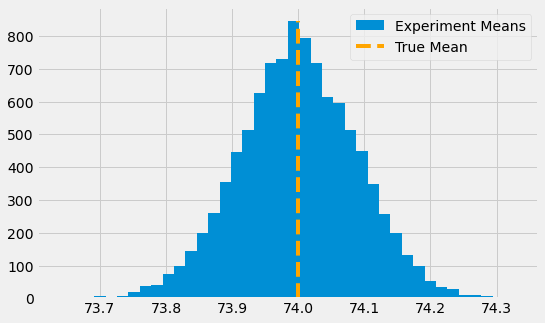

In [ ]:
true_std = 2
true_mean = 74

n = 500
def run_experiment():
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

우리는 평균들의 평균에 대해 얘기하고 있는 것을 기억하십시오. 우연하게 우리는 실험의 평균이 참 평균보다 작거나 클 수 있습니다. 이는 우리는 실험의 평균이 참 평균과 맞다고 확신할 수 없습니다. 그렇지만 **표준오차를 통해 우리는 참 평균이 95%안에 포함되도록 구간을 만들 수 있습니다.**

현실 세계에서 우리는 다양한 데이터 셋을 통해 같은 실험에 대해 여러번 실험할 수 없습니다. 그렇지만 우리는 **신뢰구간**을 만들 수 있습니다. 신뢰구간은 확률이 더해져서 구해지고 가장 일반적인 구간은 95%입니다. 이 확률은 서로 다른 연구에서 얼마나 많은 가상 신뢰구간을 만들 수 있는지 알려줍니다. 예를 들어 비슷한 연구에서 95% 신뢰구간을 계산하면 실제 평균 95%가 포함됩니다.

신뢰구간을 계산하기 위해서 우리는 **중심극한정리**(central limit theorem)를 이용합니다. 중심극한정리는 실험들의 **평균들이 정규분포를 따른다는 것**을 말하고 있어요. 우리는 통계학적 이론에서 정규분포 질량의 95%는 평균 위와 아래의 2 표준편차 사이에 있다는 것을 알고 있습니다. (정확하게는 1.96이지만, 2는 충분히 가깝습니다)

![normal_density](https://github.com/heonyun/Causal-Inference-with-Python/blob/main/causal-inference-for-the-brave-and-true/data/img/stats-review/normal_dist.jpeg?raw=1)

평균의 표준오차는 실험 평균의 분포에 대한 추정치 역할을 합니다. 따라서 만일 우리가 표준오차에서 2를 곱한 실험 평균들 중 하나를 에서 더하고 빼면 참 평균에 대한 95% 신뢰구간을 만들 수 있습니다.

In [ ]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


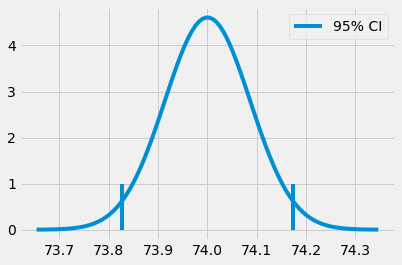

In [ ]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

당연히 우리는 95% 신뢰구간으로 제한할 필요는 없습니다. 우리는 표준편차를 곱하는데 필요한 것을 찾아 정규 분포의 질량의 99% 포함하는 신뢰구간도 만들 수 있습니다.

파이썬의 ppf 함수는 누적 분포 함수의 역함수를 알려줍니다. 85% 신뢰구간을 찾기 위해 표준오차 2를 곱하는 대신에, 99% 신뢰구간을 만들 z를 곱할 것입니다. 따라서 ppf(0.5)는 정규분포 질량의 50%가 0 아래 있음을 나타내는 0을 나타낼 것입니다. 같은 방법으로 우리가 99.5%를 넣으면 분포 질량의 99.5%가 z값 아래 형성되도록 만드는 z를 구할 것입니다. 다시 말해 분포 질량의 0.5%는 z값보다 큽니다.

In [ ]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

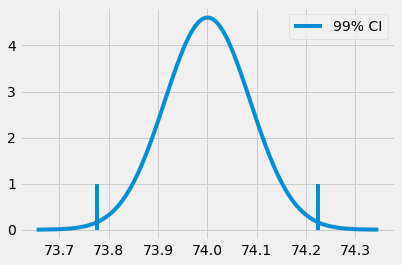

In [ ]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

우리의 교실 실험으로 돌아오겠습니다. 우리는 온라인 수업과 대면 수업의 학생들의 평균 시험 점수에 대한 신뢰구간을 만들 수 있습니다.

In [ ]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206948, 80.29218687459712)


집단 간 95% 신뢰구간이 겹치지 않습니다. 대면 수업 신뢰구간의 하한은 온라인 수업 신뢰구간의 상한보다 높습니다. 이는 대면 수업 학생들의 실제 평균 값이 온라인 수업 학생들의 실제 평균 값보다 높다는 결과가 우연적이지 않음을 나타냅니다. 다시 말해 대면 수업에서 온라인 수업으로 전환할 경우 학업 성취에 대해 유의한 인과적 감소를 주장할 수 있습니다.

요약하자면, 신뢰구간은 추정치들에 대한 불확실성을 배치하는 방법입니다. 표본이 작을 수록, 표준오차는 커지고 신뢰구간은 넓어집니다. 표준오차와 신뢰구간은 계산하기 쉽기 때문에, 신뢰구간의 신호 부족은 나쁜 의도나 지식의 부족을 의미하는데, 동등하게 우려됩니다. 마지막으로 불확실성에 대한 척도가 없다면 항상 의심하셔야합니다.

![img](https://github.com/heonyun/Causal-Inference-with-Python/blob/main/causal-inference-for-the-brave-and-true/data/img/stats-review/ci_xkcd.png?raw=1)

마지막으로 주의 한마디를 하겠습니다. 신뢰구간은 한 눈에 보는 것보다 해석하기 까다롭습니다. 예를 들면, 이 특정 95% 신뢰구간에 95% 확률로 실제 모집단 평균이 포함되어 있다고 말하면 안됩니다. 빈도주의자 입장에서 모집단 평균은 실제 모수로 간주합니다. 그렇기 때문에 우리의 특정 신뢰구간에 존재한다고 할 수 없습니다. 다시 말해, 만일 존재 한다면, 95%가 아니라 100%입니다. 만일 존재하지 않는다면 0%입니다. 대신 신뢰구간에서 95%는 많은 연구에서 계산된 신뢰구간이 실제 평균을 포함하는 빈도를 나타냅니다. 95%는 특정 간격 자체가 아니라 95%를 신뢰구간을 계산하는데 사용되는 알고리즘에 대한 우리의 신뢰도 입니다.

경제학자로서(통계학자들은 한 눈 팔아주세요 ^^) 저는 이 순수주의가 그다지 유용하다고 생각하지 않습니다. 실제로 특정 신뢰구간에 실제 평균 95%가 포함되어 있다고 말하는 사람들을 볼 수 있습니다. 틀리긴 했지만, 우리의 추정치에 대한 불확실성의 정도를 정확하게 표현한다는 점에서 유해하지는 않습니다. 게다가, 베이지안 통계학으로 바꿔서 신뢰구간 대신 신용구간을 사용한다면, 우리는 구간 안에 분포의 평균이 95% 포함되어 있다고 할 수 있습니다. 또한, 실제로 제가 본 바에 따르면, 어느 정도 큰 표본에서 빈도주의자도 인정 하시겠지만, 베이지안 확률 구간은 베이지안보다 신뢰구간에 더 유사합니다.

그러니, 만일 제 말에 중요한 것이 있다면, 신뢰구간에 대해 여러분이 원하는 어떤 것이든 자유롭게 말해주시기 바랍니다. 저는 여러분들이 실제 평균의 95% 포함하고 있다고 말해도 상관 없습니다. 여러분들의 추정치에 신뢰구간을 배치하는 것을 잊지 마세요. 그렇지 않으면 바보처럼 보일 것입니다.

## Hypothesis Testing

불확실성을 표현하는 또 다른 방법은 가설검정입니다. 평균 간 차이가 통계학적으로 0(혹은 다른 값)과 다릅니까? 독립 정규분포 2개의 합과 차는 정규분포임을 기억하십시오. 평균의 결과는 두 분포 간 합 또는 차인 반면, 분산의 결과는 항상 분산의 합이 됩니다.

$N(\mu_{1}, \sigma_{1}^2) - N(\mu_{2}, \sigma_{2}^2) = N(\mu_{1} - \mu_{2}, \sigma_{1}^2 + \sigma_{2}^2)$  

$N(\mu_{1}, \sigma_{1}^2) + N(\mu_{2}, \sigma_{2}^2) = N(\mu_{1} + \mu_{2}, \sigma_{1}^2 + \sigma_{2}^2)$  

기억 못하셔도 괜찮습니다. 우리는 항상 코드를 통해 체크할 수 있습니다.

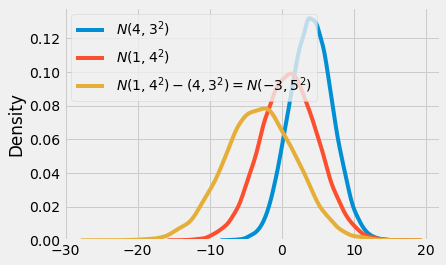

In [ ]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

만일 우리가 두 집단들의 분포에서 평균을 뺀다면, 우리는 3번째 분포를 얻게 될 것입니다. 이 최종 분포의 평균은 평균들 간 차이이고, 표준편차는 표준편차들의 합의 제곱근입니다.

$\mu_{diff} = \mu_{1} - \mu_{2}$  
$SE_{diff} = \sqrt{SE_{1} + SE_{2}} = \sqrt{\frac{\sigma_{1}^2}{n_{1}} + \frac{\sigma_{2}^2}{n_{2}}}$  

교실 예제로 돌아갑시다. 우리는 차이에 대한 분포를 만들 것입니다. 당연히 95% 신뢰구간도 만들 것입니다.

In [ ]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363357, -1.4480327880904964)


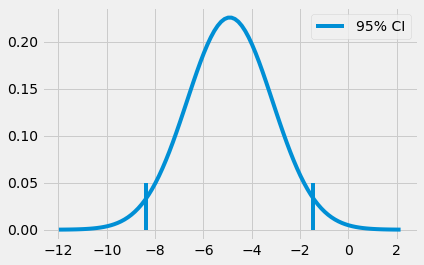

In [ ]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

이를 통해 온라인 집단과 대면 집단 간 실제 차이가 -8.37에서 -1.44 사이에 있다고 95% 신뢰할 수 있다고 할 수 있습니다. 우리는 또한 평균 간 차이에 차이에 대한 표준오차를 나누어서 z통계량을 만들 수 있습니다.  

$z = \frac{\mu_{diff}-H_{0}}{SE_{diff}} = \frac{(\mu_{1}-\mu_{2})}{\sqrt{\frac{\sigma_{1}^2}{n_{1}} + \frac{\sigma_{2}^2}{n_{2}}}}$  

$H_{0}$는 우리가 차이를 검정하고 싶은 값입니다.  
z통계량은 관측된 차이가 얼마나 극단적인지 측정해줍니다. 우리는 평균의 차이가 0과 통계적으로 다르다는 가설을 검정하기 위해 모순을 이용할 것입니다. 우리는 반대(차이가 0이다)를 참으로 가정할 것입니다. 이를 귀무가설 혹은 $H_{0}$으로 표현합니다. 그리고 우리 자신에게 "만일 진정한 차이가 0이라면 우리는 이런 차이를 관찰할 가능성이 있을까?" 물어봅니다. 우리는 이 질문을  통계학적 수학 용어로 z통계량이 0에서 얼마나 멀리 있는지 확인하는 것으로 변환할 수 있습니다.

귀무가설 하에, z통계량은 표준 정규 분포를 따릅니다. 따라서 만일 차이가 정말 0이라면, 우리는 z통계량이 평균적으로 95%의 확률로 2 표준편차 내에 확인할 수 있습니다. z가 2 표준편차보다 높거나 낮으면, 95% 신뢰도로 귀무가설을 기각할 수 있습니다.

교실예제에서 한번 살펴봅시다.

In [ ]:
z = diff_mu / diff_se
print(z)

-2.7792810791031064


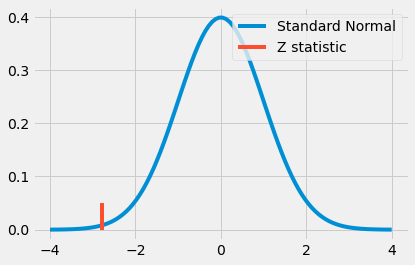

In [ ]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

꽤 극단적인 값으로 보입니다. 실제로 2보다 큰데, 이는 집단 간 차이가 없다면 우리가 이런 극단적인 값을 볼 확률이 5% 미만을 의미합니다. 이는 또한 대면 수업에서 온라인 수업으로 전환하는 것이 통계적으로 유의미한 학업 성취도를 떨어뜨린다는 결론을 내리게 합니다.

가설검정의 마지막 흥미로운 점은 처리된 집단과 처리되지 않은 집단의 95% 신뢰구간이 겹치는지 확인하는 것보다 덜 보수적이라는 점입니다. 다시 말해 만일 두 집단 간 신뢰구간이 겹친다 하더라도 통계적으로 유의할 수 있습니다. 예를 들어 대면 집단이 평균 80점에, 표준오차 4, 온라인 집단이 평균 71점에 표준오차 2를 받았다고 가정합시다.

In [ ]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


만일 우리가 두 집단에 대해 신뢰구간을 만들면 겹칩니다. 온라인 집단의 상한은 74.92이고 대면 집단의 하한은 72.16입니다. 그러나 집단 간 차이에 대한 95% 신뢰구간을 계산하면 0이 포함되지 않습니다. 개별 신뢰구간이 겹치더라도 여전히 통계학적으로 0과 다를 수 있습니다.

## P-values

이전에 저는 온라인 집단과 대면 집단의 차이가 실제로 0이라면 우리가 이러한 극단적인 값을 관찰할 확률은 5% 미만이라고 말했습니다. 하지만 우리가 그 가능성을 정확히 예측할 수 있을까요? 우리가 이러한 극단적인 값을 관찰할 가능성이 얼마나 될까요? p값을 입력하세요!

신뢰구간(사실 가장 빈도주의 통계학)과 마찬가지로 p값으 진정한 정의는 매우 헷갈릴 수 있습니다. 따라서 어떠한 위험도 감수하지 않기 위해 위키피디아에서 정의를 복사해왔습니다. "p값은 귀무가설이 올바르다고 가정할 때, 검정 중에 실제 관찰될 수 있는 가장 극단적인 검정결과를 얻을 확률입니다"

좀 더 간결히 설명하면, 귀무가설이 참이라는 가정하에 p값은 그러한 데이터를 볼 확률입니다. 귀무가설이 참일 경우 측정값을 볼 가능성이 얼마나 낮은지를 측정합니다. 자연스럽게 이는 귀무가설이 참일 확률과 혼동됩니다. 여기서 차이점을 주의하십시오. p값은 $P(H_{0}|data)$가 아니라 $P(data|H_{0})$입니다.

하지만 이런 복잡함이 당신을 속이게 하지 마십시오. 실용적인 측면에서 사용하기 쉽습니다.

p값을 구하려면, z통계량 전후에 표준 정규분포 면적을 계산해야합니다. 다행히도, 이 계산을 해 줄 컴퓨터가 있습니다. 누적 표준 정규분포에 z통계량을 넣으면 됩니다.

In [ ]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835564706


p값은 95% 혹은 99%와 같은 신뢰수준을 지정할 필요 없기에 흥미롭습니다. 하지만 p값에서 하나를 보고자 하는 경우 어떤 신뢰 수준에서 우리의 검정이 합격 혹은 불합격인지 정확히 알 수 있습니다. 예를 들어 p값이 0.0027이라면, 유의수준이 0.2%임을 알 수 있습니다. 따라서 95% 신뢰구간과 99% 신뢰구간에서는 0이 포함되지 않지만, 99.9% 신뢰구간에서는 포함됩니다. 이는 만일 차이가 0이라면 이 극단적인 z통계량을 관측할 확률이 0.2%임을 의미합니다.

In [ ]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.37634655308288, -1.4480964433709733)
99% CI: (-9.464853535264012, -0.3595894611898425)
99.9% CI: (-10.72804065824553, 0.9035976617916743)


## Key Ideas

이번 챕터에서 Moivre의 공식을 아는 것이 얼마나 중요한지 보았고, 그것이 우리 추정치에 어느정도 확신이 되는지 알기 위해 사용했습니다. 우리는 온라인 수업이 대면 수업에 비해 학업성취도 저하를 유발하는 것을 알아냈습니다. 우리는 또한 통계학적으로 유의한 결과임을 확인했습니다. 우리는 두 집단의 평균 신뢰구간을 비교하고, 차이에 대한 신뢰구간을 살펴보고, 가설검정을 수행했고 p값을 확인했습니다. 이전에 했던 것 처럼 단일 A/B 테스트 비교 함수를 만드는 것으로 이번 장을 마무리하려고 해요.

In [ ]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))

    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))

    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)

    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)

    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")

AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.5474845833333 +- 1.7097768273108
Test-Control 95.0% CI: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.7792810791031064
P-Value 0.0027239680835564706


위 함수는 충분히 일반적이기 때문에, 다른 귀무가설 검정도 할 수 있어요. 예를 들어, 온라인과 대면 수업의 효과 차이가 -1인지 기각할 수 있을까요? 우리가 얻는 결과를 통해 우리는 95% 신뢰도를 통해 차이가 -1보다 유의하다고 할 수 있습니다. 그렇지만 99% 신뢰도로는 할 수 없습니다.

In [ ]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.5474845833333 +- 1.7097768273108
Test-Control 95.0% CI: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.2134920404560723
P-Value 0.013431870694630667


## References

이 책을 쓰기 위해 Joshua Angrist, Alberto Abadie, Christopher Walters의 대단한 계량 경제학 수업 자료를 많이 참고했습니다. 해당 자료에 있는 대부분의 아이디어는 전미경제학회(American Economic Association)의 수업에서 가져왔어요. 이렇게 좋은 참고자료를 보는 것이 2020년의 힘든 한 해를 지탱하게 만들어준 원동력이었다고 생각해요.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

또한, Angrist의 정말 좋은 책들을 참고자료에 넣고 싶어요. 해당 저자가 쓴 책들은 계량경제학(Econometrics) 또는 '메트릭스(Metrics, 계량적 분석)'가 매우 유용할 뿐만 아니라 매우 흥미롭다는 걸 알려주었어요.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering ‘Metrics](https://www.masteringmetrics.com/)

마지막으로 참고한 자료는 Miguel Hernan과 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 까다로운 인과적인 질문에서 신뢰할 수 있는 동반자 같은 존재였어요.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

해당 챕터에서 사용된 데이터는 해당 논문의 자료를 참조했습니다. Alpert, William T., Kenneth A. Couch, and Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057)

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 모든 분들이 쉽게 접근하실 수 있도록 하는 것이 목표입니다. 또한, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요.
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [한국어 번역 자료](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/stargazers)와 [해당 번역본의 원서](https://github.com/matheusfacure/python-causality-handbook/stargazers)에 star 부탁드립니다!